In [55]:
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from Interaction_effect_features import get_data

import warnings
warnings.filterwarnings('ignore')
np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [42]:
def last_preprocessing(data_dict,feature_columns,dependent_variable,dataset):
    
    if dataset == 'regression':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    else:
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    
    for feature in columns:
        if feature in feature_columns and feature in data_dict['data_external_test'].columns:
            data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
            data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

            for index in data_dict['fold_dict'].keys():
                data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
    
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_training'])
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_validation_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_external_test'])
    
    fold_training = data_dict['fold_dict'][1]['fold_training'][feature_columns+dependent_variable]
    fold_test = data_dict['fold_dict'][1]['fold_test'][feature_columns+dependent_variable]
    data_validation_test = data_dict['data_validation_test'][feature_columns+dependent_variable]
    data_external_test = data_dict['data_external_test'][feature_columns+dependent_variable]
    
    #append
    training_df = fold_training.append([fold_test, data_validation_test], ignore_index=True)
    training_df.reset_index(inplace=True,drop=True)
    
    return training_df,data_external_test

def last_preprocessing_surrogate(data_dict,feature_columns,dependent_variable,dataset):
    
    if dataset == 'regression':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    else:
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    
    for feature in columns:
        if feature in feature_columns and feature in data_dict['data_external_test'].columns:
            data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
            data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

            for index in data_dict['fold_dict'].keys():
                data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
    
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_training'])
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_validation_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_external_test'])
    
    fold_training = data_dict['fold_dict'][1]['fold_training'][feature_columns+dependent_variable]
    fold_test = data_dict['fold_dict'][1]['fold_test'][feature_columns+dependent_variable]
    data_validation_test = data_dict['data_validation_test'][feature_columns+dependent_variable]
    data_external_test = data_dict['data_external_test'][feature_columns+dependent_variable]
    
    #append
    training_df = fold_training.append([fold_test], ignore_index=True)
    training_df.reset_index(inplace=True,drop=True)
    
    return training_df,data_validation_test,data_external_test

In [43]:
#features_regression = 
with open(r"D:\Results\ResultPickle\PredictRoomBooking\best_columns_GA_PredictRoomBooking_lightgbm_v4.pickle", "rb") as features_regression:
    features_regression = pickle.load(features_regression)

#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'PredictRoomBooking'
data_dict_regression,dependent_variable_regression,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

#create single dataframe
training_df_regression,data_external_test_regression = last_preprocessing(data_dict=data_dict_regression,
                                                    feature_columns=features_regression,
                                                    dependent_variable=dependent_variable_regression,
                                                    dataset='regression')

#create dataframe for surrogate
training_df_surrogate,data_validation_test_surrogate,data_external_test_surrogate = last_preprocessing_surrogate(data_dict=data_dict_regression,
                                                                                   feature_columns=features_regression,
                                                                                   dependent_variable=dependent_variable_regression,
                                                                                   dataset='regression')

# Train Models

In [56]:
regression_model = LGBMRegressor(n_estimators=200,random_state=1,n_jobs=-1)
regression_model.fit(training_df_regression[features_regression],training_df_regression[dependent_variable_regression])

LGBMRegressor(n_estimators=200, random_state=1)

## Partial Dependence Plot

In [45]:
from sklearn.inspection import PartialDependenceDisplay

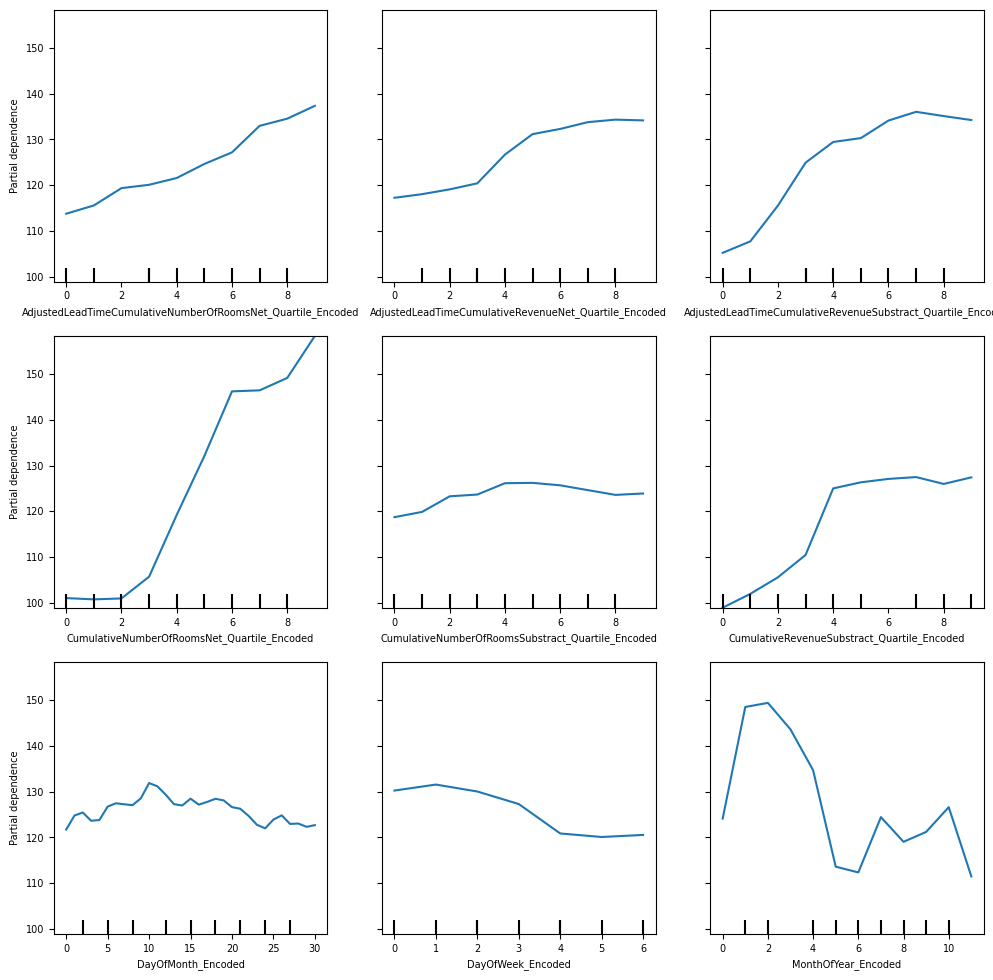

In [46]:
plt.rcParams["figure.figsize"] = (12,12)
PartialDependenceDisplay.from_estimator(regression_model, training_df_regression[features_regression], features_regression)
plt.show()

## Accumulated Local Effects Plot

In [47]:
from alibi.explainers import ALE, plot_ale

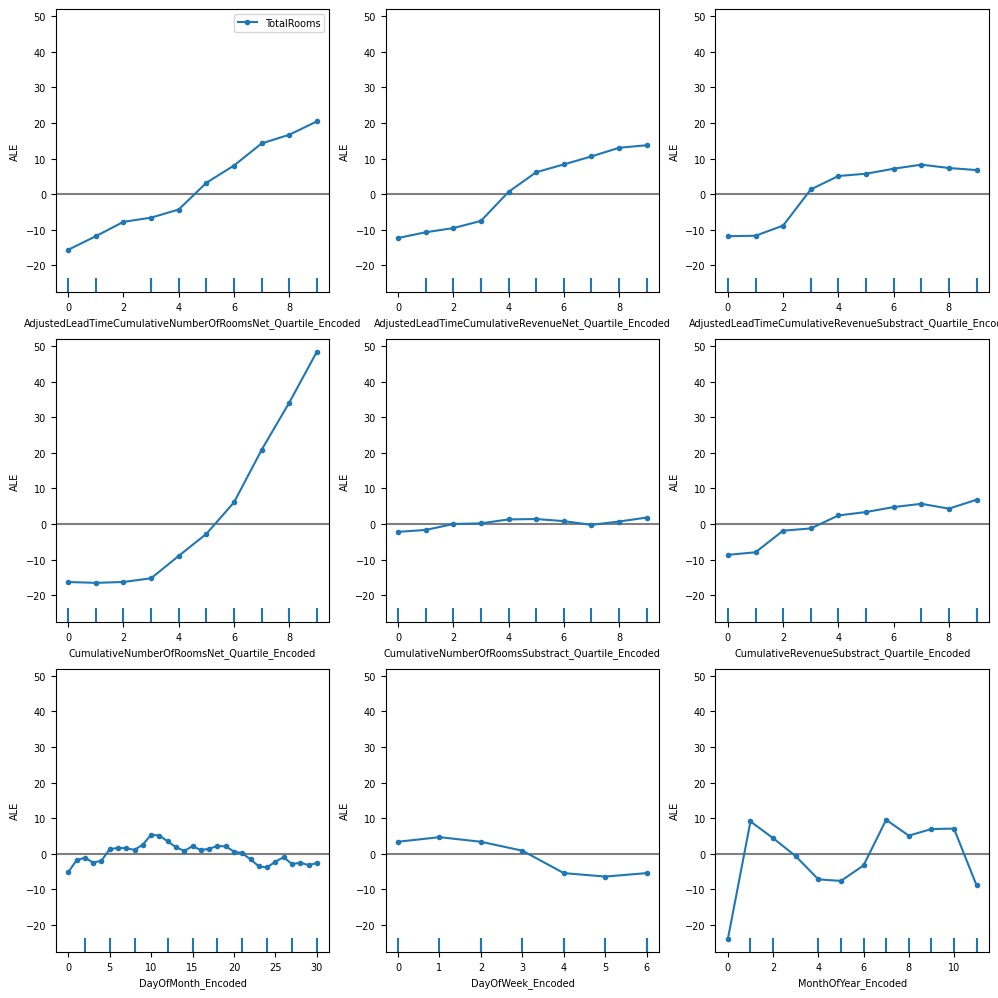

In [48]:
SMALL_SIZE = 7
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

regression_ale = ALE(regression_model.predict,feature_names=features_regression,target_names=dependent_variable_regression)
regression_explain = regression_ale.explain(np.array(training_df_regression[features_regression]))
plot_ale(regression_explain,fig_kw={'figwidth':10,'figheight':10})
plt.show()

## Permutation Feature Importance

In [49]:
from rfpimp import importances, plot_importances

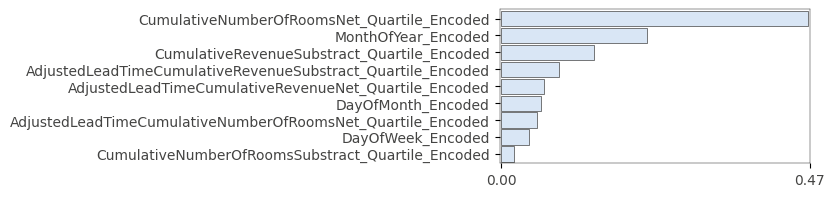

In [50]:
imp = importances(regression_model, training_df_regression[features_regression], training_df_regression[dependent_variable_regression]) # permutation
viz = plot_importances(imp)
viz.view()

## Surrogate Model

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [52]:
#train
regression_model.fit(training_df_surrogate[features_regression],training_df_surrogate[dependent_variable_regression])

#predict for external test
data_validation_test_surrogate['surrogate'] = regression_model.predict(data_validation_test_surrogate[features_regression])

regression_model_surrogate = LinearRegression(n_jobs=-1)
regression_model_surrogate.fit(data_validation_test_surrogate[features_regression],data_validation_test_surrogate['surrogate'])

data_external_test_surrogate['surrogate'] = regression_model_surrogate.predict(data_external_test_surrogate[features_regression])

print('RMSE on external test data is:',np.sqrt(mean_squared_error(data_external_test_surrogate[dependent_variable_regression],data_external_test_surrogate['surrogate'])))

RMSE on external test data is: 30.68407224795604
